# Weibull AFT final model:
SHAP values (1000 background samples, i = 1000)

# setup


In [6]:
import joblib
import matplotlib
import matplotlib.pyplot as plt
# import mlflow
import numpy as np
import pandas as pd
import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lifelines import WeibullAFTFitter
import shap

import os, sys
currentdir = r"C:\Users\tlinden\Documents\Git\leoss\reports\CV\weiAft_CV_SHAP3-plots.ipynb"
ppdir = r"C:\Users\tlinden\Documents\Git\leoss"
sys.path.append(ppdir)
import utils.general

ENDPOINT = "death"
MODEL = "weiAft_CV"

## helpers

In [7]:
# https://github.com/slundberg/shap/issues/1420#issuecomment-715190610
class ShapObject:    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

class Model_Shap():
    def __init__(self, encoder, scaler, model) -> None:
        self.encoder = encoder
        self.scaler = scaler
        self.model = model            
    def predict(self, X):
        # transform
        X_t = self.encoder.transform(X)
        X_t = self.scaler.transform(X_t)
        X_t = pd.DataFrame(X_t, columns=self.encoder.get_feature_names())
        X_t.reset_index(drop=True, inplace=True)
        # predict
        # return self.model.predict_survival_function(X_t).T
        # return self.model.predict_hazard(X_t)
        return self.model.predict_percentile(X_t) # median lifetimes

# data: load + preprocess

In [8]:

# data = pd.read_pickle("./data/processed/leoss_decoded.pkl", compression="zip")
# data_items = pd.read_csv("./data/interim/data_items.txt", sep="\t")
data = pd.read_pickle(r"C:\Users\tlinden\Documents\Git\leoss\data\processed\leoss_decoded.pkl", compression="zip")
data_items = pd.read_csv(r"C:\Users\tlinden\Documents\Git\leoss\data\interim\data_items.txt", sep="\t")

# decide which data to be used further
X = utils.general.filter_featurecols(data, data_items)
# unify unknown / missingness
to_replace = ["Unknown","unknown", "None", "not done/unknown", "Not done/unknown", "Not determined/ Unknown"]
for rpl in to_replace:
    X.replace(rpl,"missing",inplace=True)
# replace na's with missing, otherwise onehotencoder fails
X.fillna("missing", inplace=True)
# preprocess endpoint specific
X, y = utils.general.make_data_death(data, X)

# get X subset (same as used before for estimation of shap values)
random_state = 42
n = 1000
X_sample = X.sample(n=n, random_state=random_state).reset_index(drop=True)
y_sample = y.sample(n=n, random_state=random_state).reset_index(drop=True)
y_sample_status = y.status.sample(n=n, random_state=random_state).reset_index(drop=True)

endpoint death 738/6239 = 11.8 %



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# reload final model

In [9]:
fname_model = r"C:\Users\tlinden\Documents\Git\leoss\mlruns\0\f2b69f7332324cd9b65b1c25303dfc36\artifacts\leoss_weiAft_CV_death_CV.pkl.gzip"
# fname_model = "/home/tlinden/leoss/mlruns/0/f2b69f7332324cd9b65b1c25303dfc36/artifacts/leoss_weiAft_CV_death_CV.pkl.gzip"
pipe_ = joblib.load(fname_model)
enc = pipe_[0][1]
scaler = pipe_[1][1]
model = pipe_[2][1]

# wrap model components in class with .predict() method
model_shap = Model_Shap(enc,scaler,model)

Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


#  load SHAP model + values

In [10]:
random_state = 42
# load SHAP data
explainer = joblib.load(r"C:\Users\tlinden\Documents\Git\leoss\models\CV\leoss_weiAft_CV_SHAP-explainer-n1000-idefault.pkl.gz")
shap_values = joblib.load(r"C:\Users\tlinden\Documents\Git\leoss\models\CV\leoss_weiAft_CV_SHAP-shap_values-n1000-idefault.pkl.gz")


Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


# SHAP plots

SHAP values estimate a features contribution on the predicted value.
The predicted value is the median lifetimes of indivduals: [lifelines `predict_percentile`](https://lifelines.readthedocs.io/en/latest/fitters/regression/WeibullAFTFitter.html#lifelines.fitters.weibull_aft_fitter.WeibullAFTFitter.predict_percentile).

The SHAP values denote impact on median lifetimes in days. The average lifetime across samples is shown below as `explainer.expected_value"`


In [11]:
explainer.expected_value

124.00199559755598

## summary plot, top-20

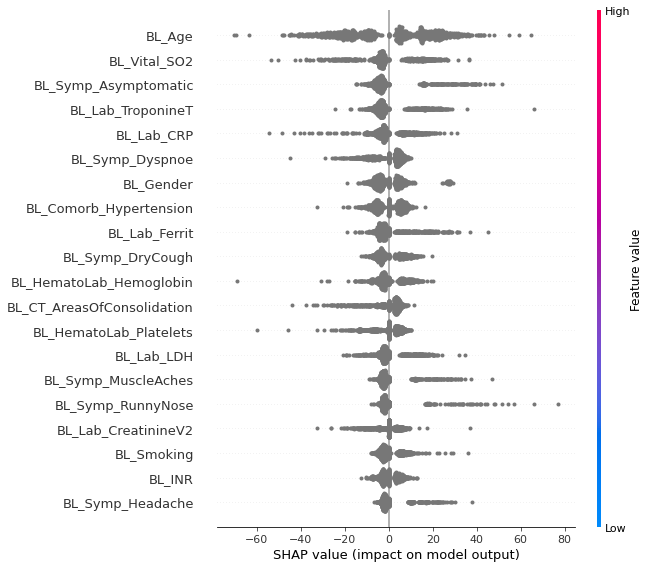

In [23]:
shap.summary_plot(shap_values, X_sample, max_display=20, title = "top 20 features")

## dependence plot - top10

The additional y-axis on the right shows interaction in relationship to the main variable (left y-axis).
The variable on the right y-axis was inferred automatically.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


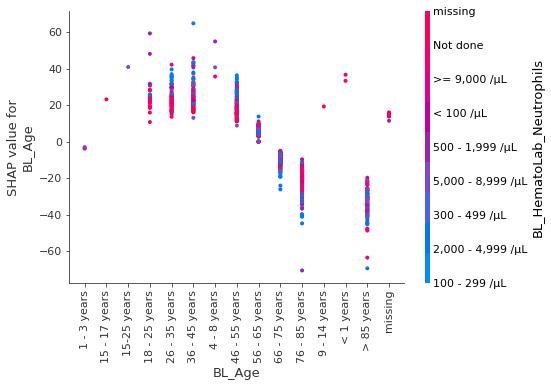

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


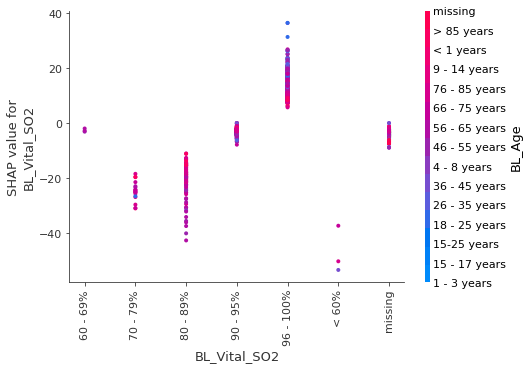

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


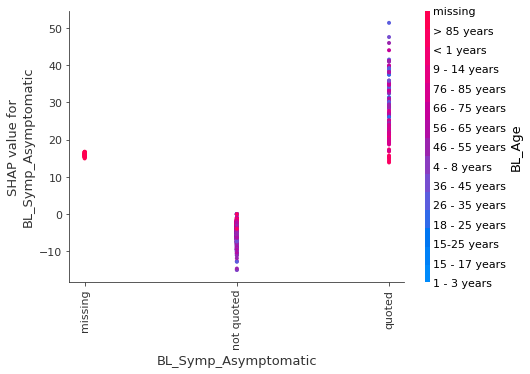

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


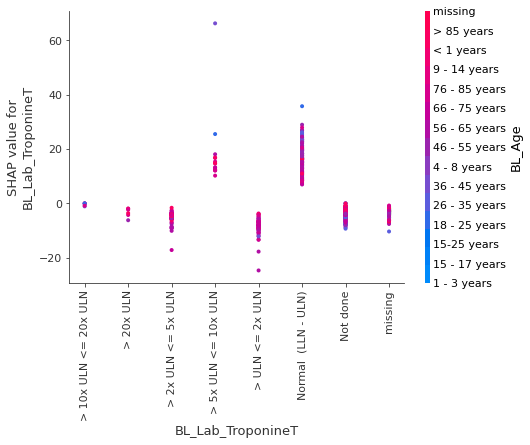

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


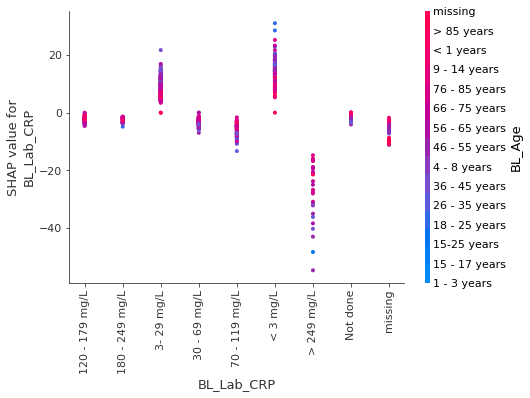

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


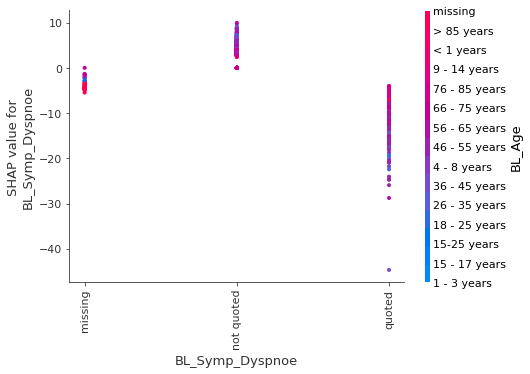

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


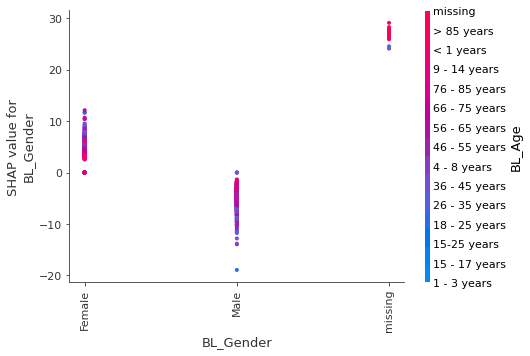

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


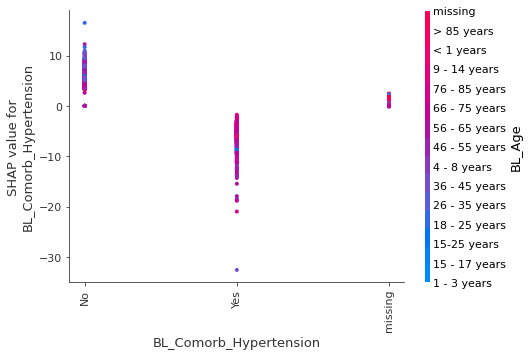

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


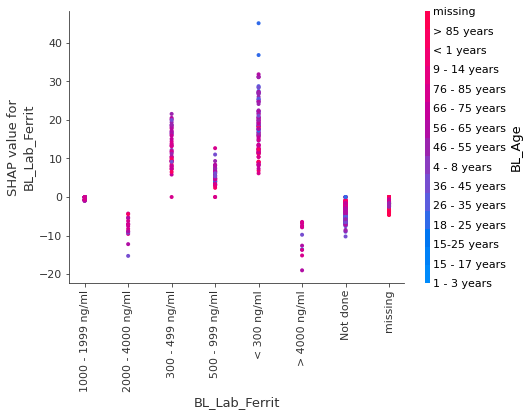

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


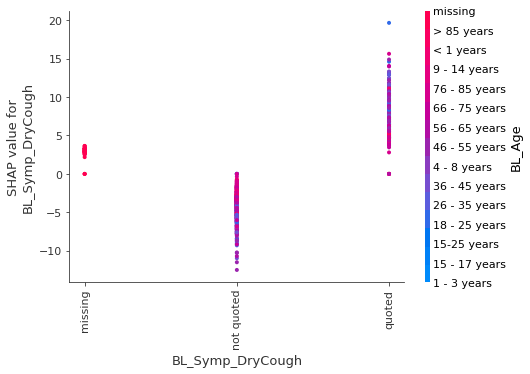

In [13]:
for i in range(10):
    shap.dependence_plot(f"rank({i})", shap_values, X_sample)

## group difference plot (events vs censored) of the sample subset (1000 patients)
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.group_difference_plot.html


FixedFormatter should only be used together with FixedLocator


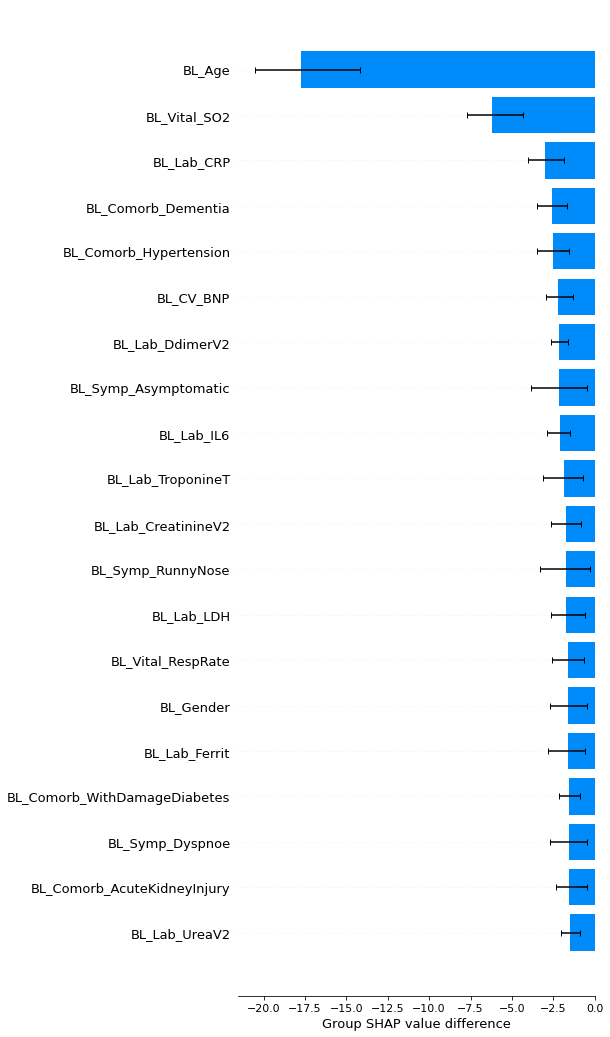

In [14]:
shap.group_difference_plot(
    shap_values,
    y_sample_status, 
    feature_names=X.columns,
    max_display=20)

In [15]:
# group stats:
y_sample_status.value_counts()

False    861
True     139
Name: status, dtype: int64

## top 10 high risk patients waterfall plot
- only patients who had an event
- high risk = early event (death)

In [16]:
highrisk_top10 = y_sample[y_sample.status==True].nsmallest(10, "time")
highrisk_top10_idx = highrisk_top10.index.to_list()
highrisk_top10



,status,time
64,True,1
284,True,1
324,True,1
467,True,1
591,True,1
877,True,1
901,True,1
67,True,2
213,True,2
330,True,2


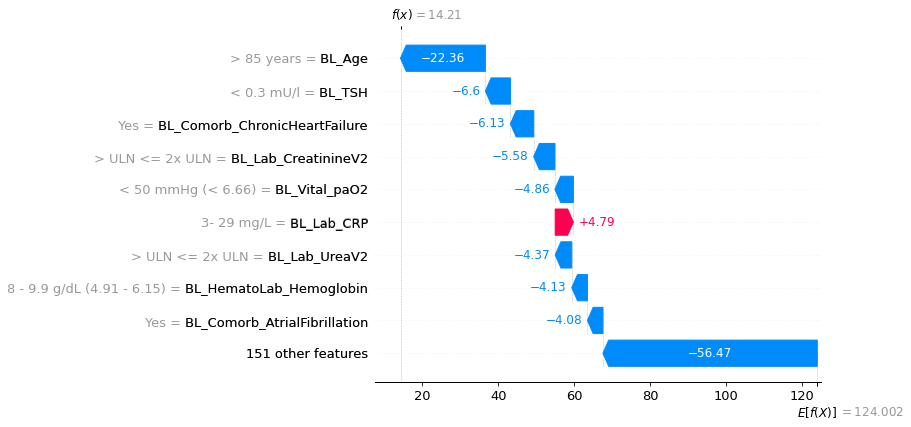

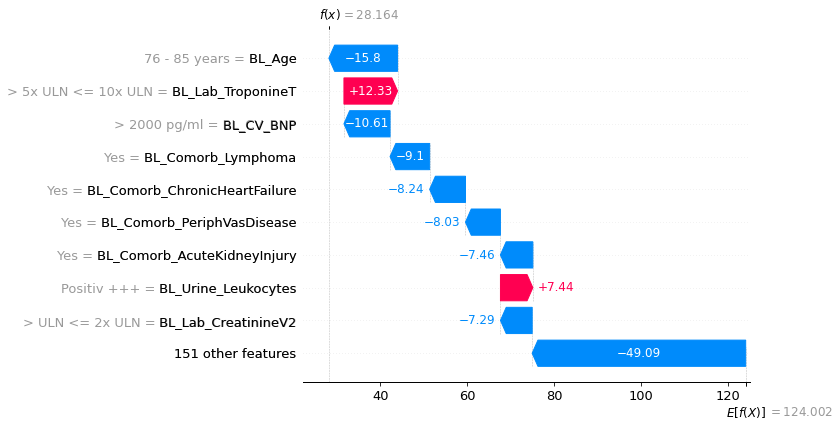

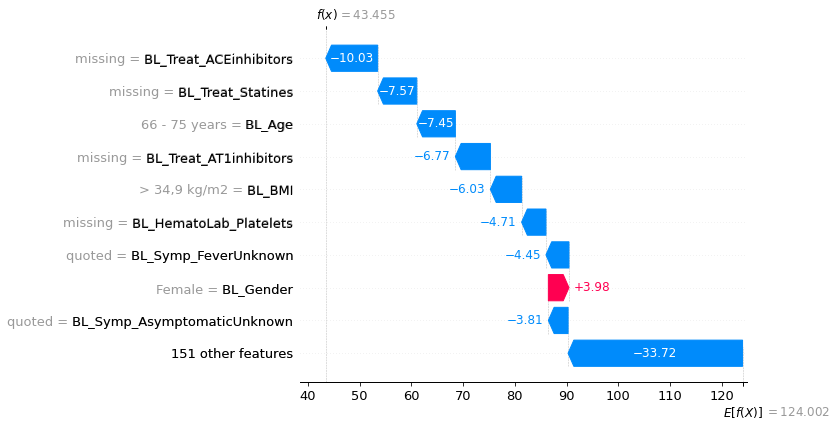

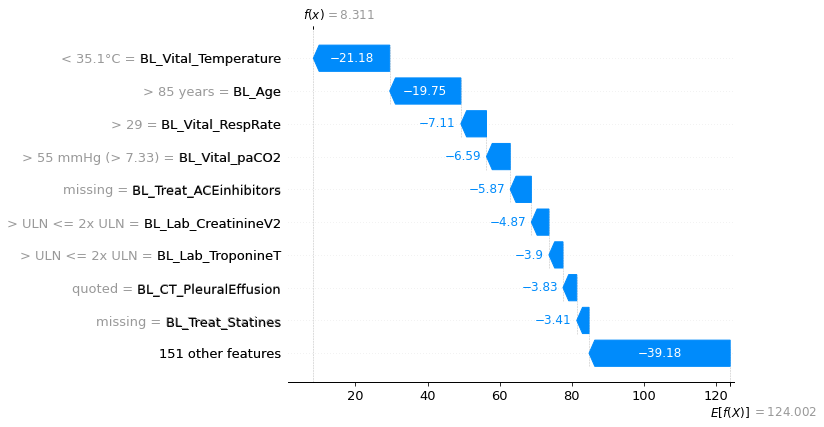

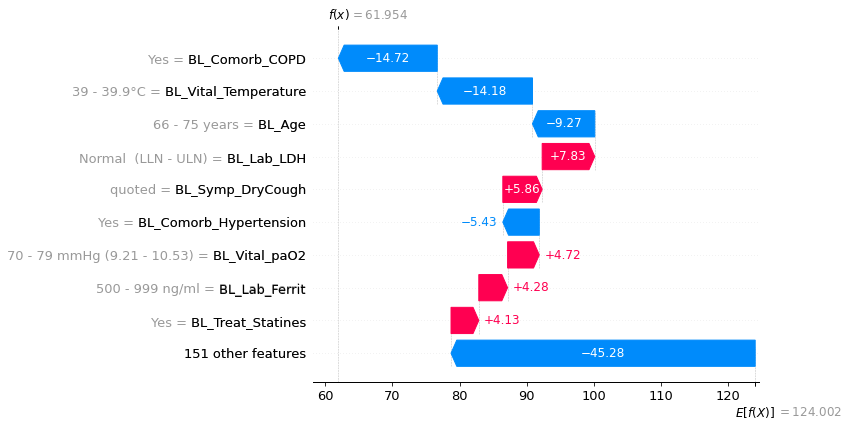

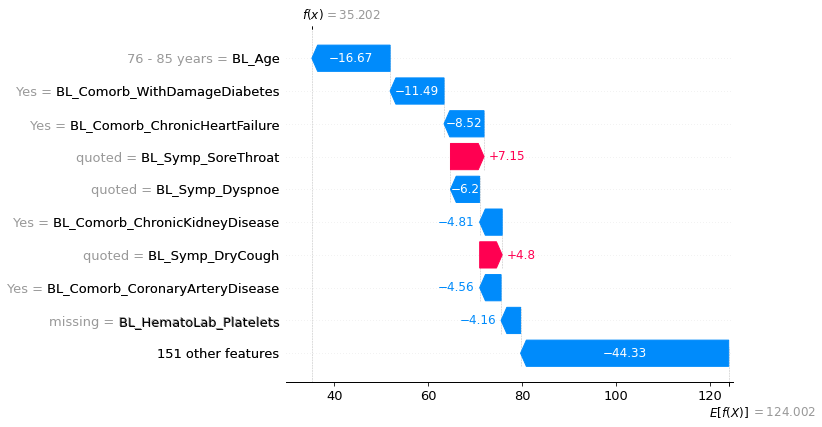

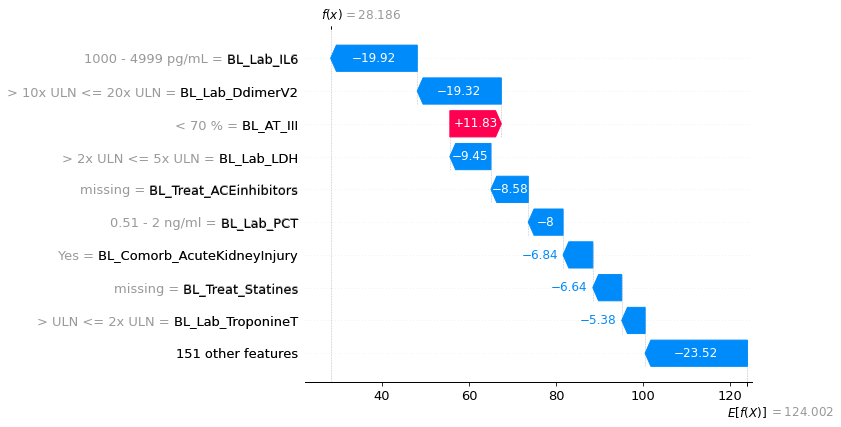

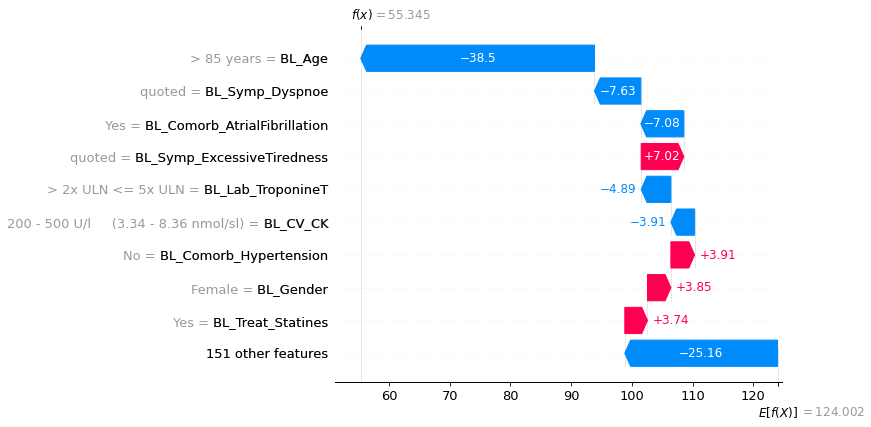

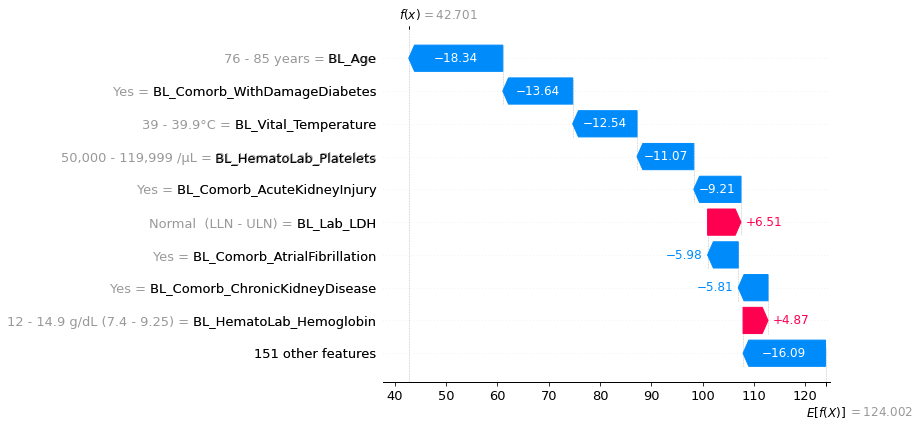

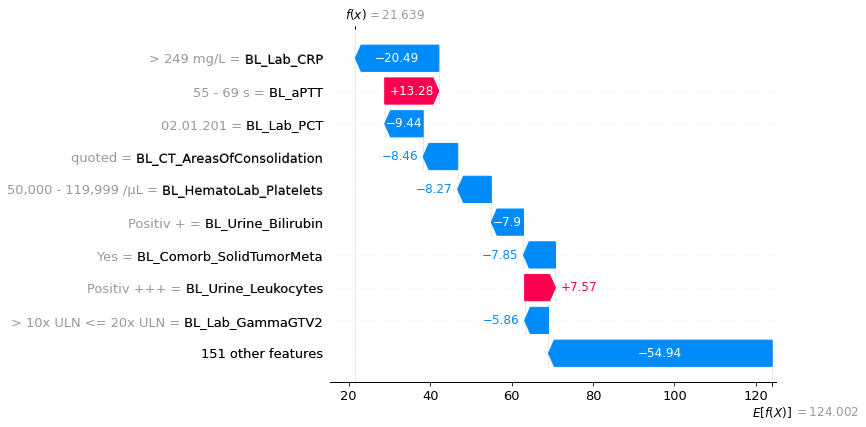

In [17]:
for i in highrisk_top10_idx:    
    shap_object = ShapObject(base_values = explainer.expected_value,
                         values = shap_values[i,:],
                         feature_names = X.columns,
                         data = X_sample.iloc[i,:])
    shap.waterfall_plot(shap_object)

## SHAP low risk patients waterfall
- patients who survived longest without an event (censored)

In [18]:
lowrisk_top10 = y_sample[y_sample.status==False].nlargest(10,"time")
lowrisk_top10_idx = lowrisk_top10.index.to_list()
lowrisk_top10


,status,time
383,False,78
401,False,78
465,False,78
499,False,78
562,False,78
572,False,78
672,False,78
669,False,71
941,False,71
221,False,64


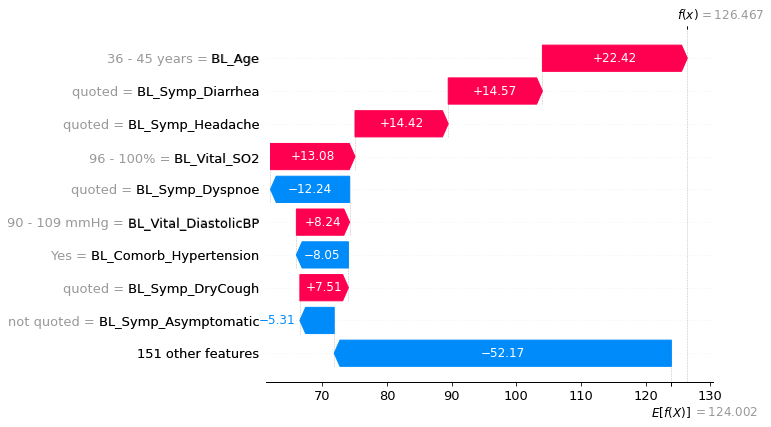

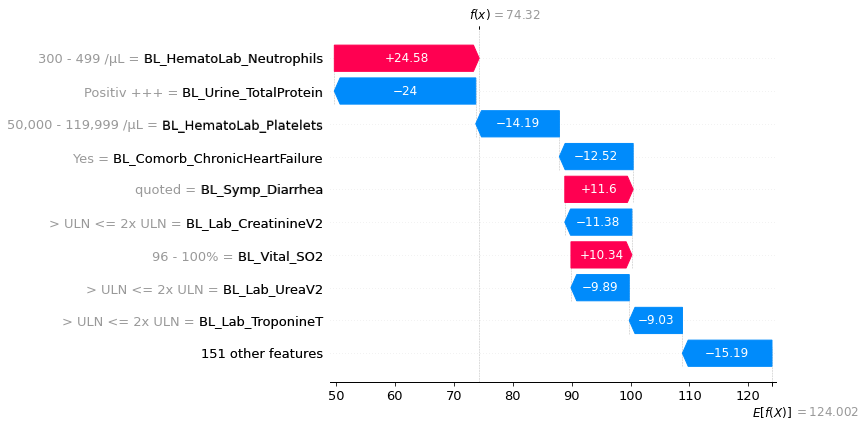

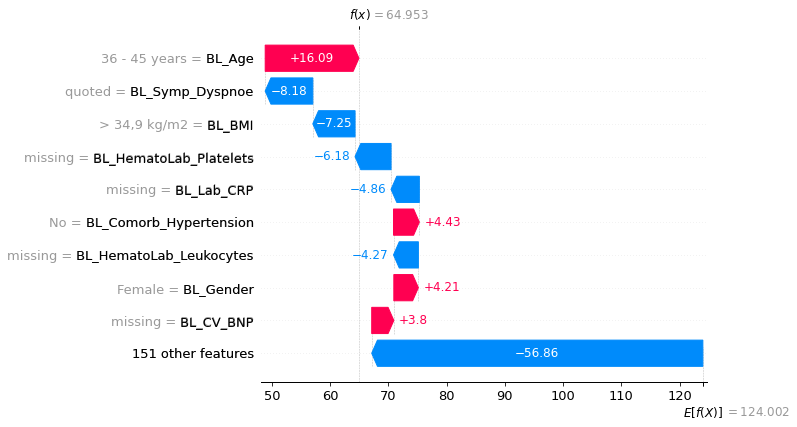

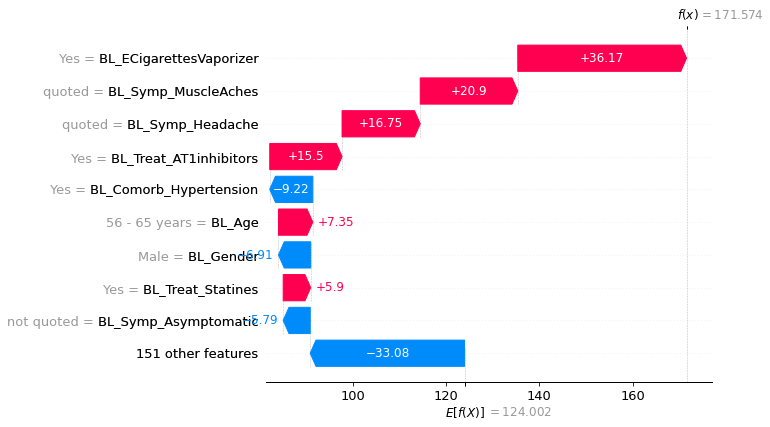

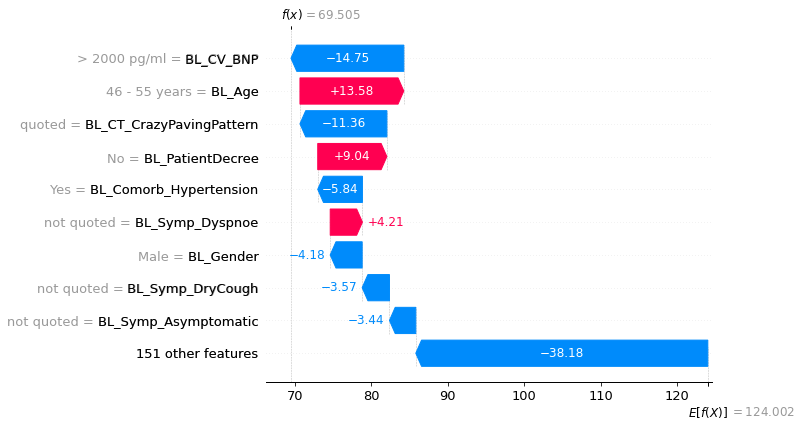

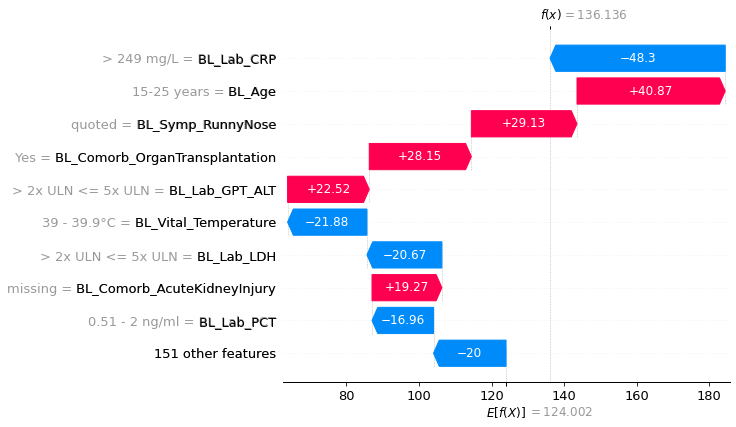

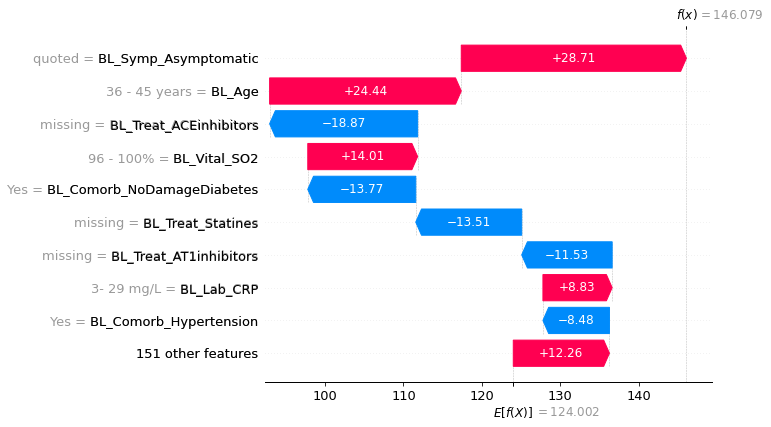

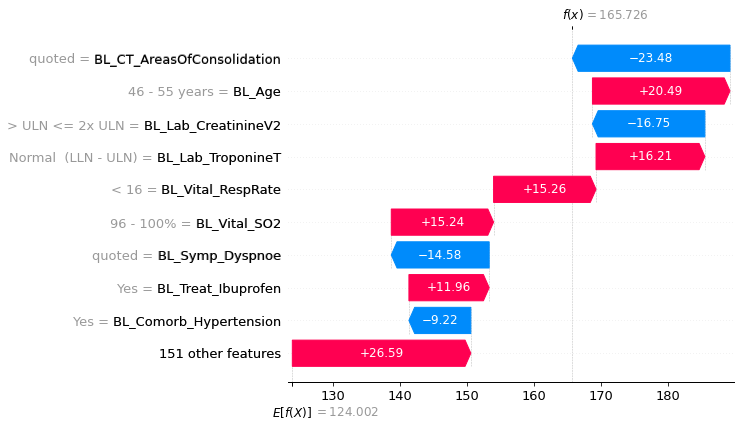

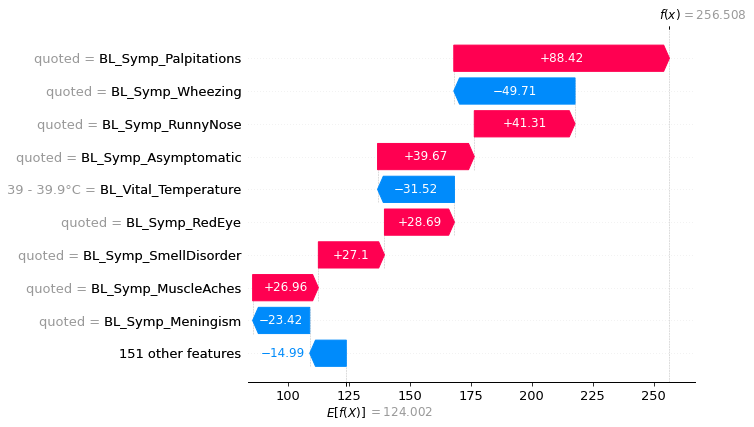

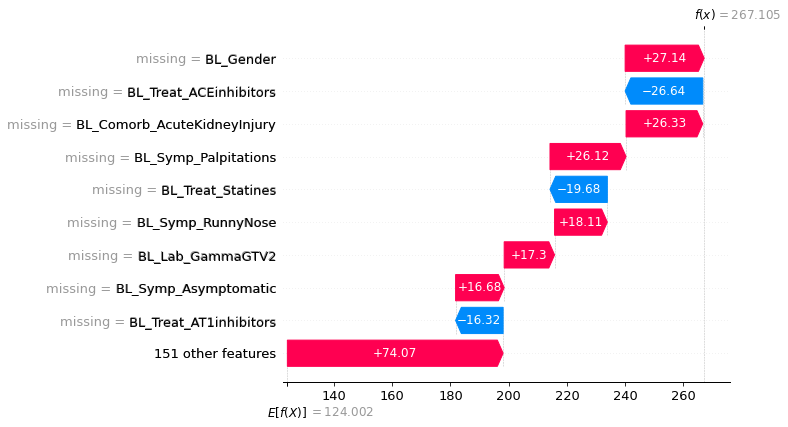

In [19]:
for i in lowrisk_top10_idx:    
    shap_object = ShapObject(base_values = explainer.expected_value,
                         values = shap_values[i,:],
                         feature_names = X.columns,
                         data = X_sample.iloc[i,:])
    shap.waterfall_plot(shap_object)